Download *EqM* onto Drive as EqM-B_2: https://drive.google.com/uc?id=1kDZGOri7Hf4CgnJAdEDguWooY3al37T6

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!find /content/drive/MyDrive -name "EqM-B_2pt"


/content/drive/MyDrive/EqM-B_2pt


In [15]:
%cd /content
!rm -rf EqM
!git clone https://github.com/raywang4/EqM.git
%cd EqM
!ls


/content
Cloning into 'EqM'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 25 (delta 5), reused 4 (delta 4), pack-reused 12 (from 1)
Receiving objects: 100% (25/25), 362.98 KiB | 40.33 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/EqM
download.py	 LICENSE    sample_gd.py  train_utils.py
environment.yml  models.py  sample.py	  transport
eqm.png		 README.md  train.py	  wandb_utils.py


In [16]:
# --- 1. Clean up any old nested folders ---
%cd /content
!rm -rf EqM
!git clone https://github.com/raywang4/EqM.git
%cd EqM

# --- 2. Install dependencies ---
!pip install torch torchvision tqdm Pillow numpy einops omegaconf gdown --quiet

# --- 3. Download pretrained EqM-B/2 checkpoint (2 GB) ---

!mkdir -p /content/EqM/checkpoints
!cp "/content/drive/MyDrive/EqM-B_2pt" /content/EqM/checkpoints/EqM-B2.pt
!ls -lh /content/EqM/checkpoints/



# Confirm it downloaded
!ls -lh checkpoints/

/content
Cloning into 'EqM'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 25 (delta 5), reused 4 (delta 4), pack-reused 12 (from 1)
Receiving objects: 100% (25/25), 362.98 KiB | 21.35 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/EqM
total 2.0G
-rw------- 1 root root 2.0G Oct 30 18:35 EqM-B2.pt
total 2.0G
-rw------- 1 root root 2.0G Oct 30 18:35 EqM-B2.pt


In [17]:
!pip install torchdiffeq

In [18]:
import argparse
from torch.serialization import add_safe_globals

# Allow argparse.Namespace to be deserialized (safe for trusted EqM checkpoint)
add_safe_globals([argparse.Namespace])
print("✅ Patched PyTorch safe loading.")


✅ Patched PyTorch safe loading.


In [19]:
import pathlib, re, os
os.chdir("/content/EqM")

# Load the original sample_gd.py
src = pathlib.Path("sample_gd.py").read_text()

# 1) Skip distributed initialization
src = re.sub(
    r"dist\.init_process_group\(.*?\)",
    "print('[patched] skipping dist.init_process_group')",
    src,
)

# 2) Replace DDP wrapping with single-GPU model
src = re.sub(
    r"model\s*=\s*DDP\(model[^\)]*\)",
    "print('⚠️  Using non-DDP single-GPU mode (Colab patch).')\n    model = model.to(device)",
    src,
)

# 3) Save as new patched file
pathlib.Path("sample_gd_nodist3.py").write_text(src)
print("✅ Created sample_gd_nodist3.py (Colab safe single-GPU version)")


✅ Created sample_gd_nodist3.py (Colab safe single-GPU version)


In [20]:
import sys, os, argparse, torch
from torch.serialization import add_safe_globals
add_safe_globals([argparse.Namespace])

os.environ.update({
    "RANK": "0",
    "WORLD_SIZE": "1",
    "LOCAL_RANK": "0",
    "MASTER_ADDR": "localhost",
    "MASTER_PORT": "12355",
})

%cd /content/EqM
sys.path.append(".")

import importlib
sample_gd = importlib.import_module("sample_gd_nodist3")

# 1) skip npz
def _skip_npz(*a, **k): print("⚠️ Skipping NPZ creation.")
sample_gd.create_npz_from_sample_folder = _skip_npz

# 2) force rank-0 + no-op cleanup
import torch.distributed as dist
dist.get_rank = lambda : 0
dist.get_world_size = lambda : 1
dist.barrier = lambda : None
sample_gd.cleanup = lambda: print("⚠️ Skipping dist cleanup (single-GPU Colab).")
dist.destroy_process_group = lambda *a, **k: print("⚠️ destroy_process_group() skipped.")

# args
class Args:
    model = "EqM-B/2"
    image_size = 256
    num_classes = 1000
    global_batch_size = 1
    global_seed = 0
    vae = "ema"
    cfg_scale = 1.0
    ckpt = "checkpoints/EqM-B2.pt"
    stepsize = 0.0017
    num_sampling_steps = 256
    folder = "generated"
    sampler = "gd"
    mu = 0.3
    num_fid_samples = 4
    uncond = True
    ebm = "none"
    path_type = "Linear"
    prediction = "velocity"
    loss_weight = "None"
    sample_eps = 0.0
    train_eps = 0.0

args = Args()

print("✅ Forced single-GPU rank=0 mode.")
sample_gd.main(args)


/content/EqM
✅ Forced single-GPU rank=0 mode.
[patched] skipping dist.init_process_group
Found 1 GPUs, trying to use device index 0
Starting rank=0, seed=0, world_size=1.
⚠️  Using non-DDP single-GPU mode (Colab patch).


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


EqM Parameters: 130,512,416
Total number of images that will be sampled: 4


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]

Creating .npz file
⚠️ Skipping NPZ creation.
Done!
⚠️ Skipping dist cleanup (single-GPU Colab).


found 8 pngs
/content/EqM/generated/000000.png


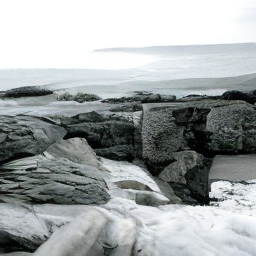

/content/EqM/generated/000000.png


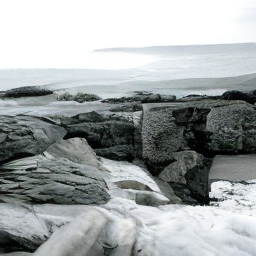

/content/EqM/generated/000001.png


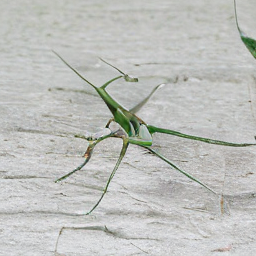

/content/EqM/generated/000001.png


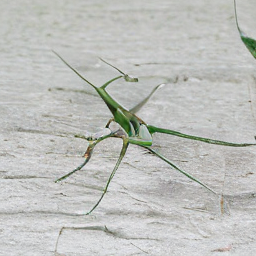

/content/EqM/generated/000002.png


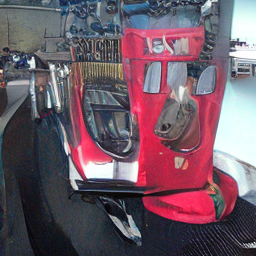

/content/EqM/generated/000002.png


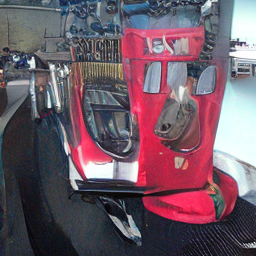

/content/EqM/generated/000003.png


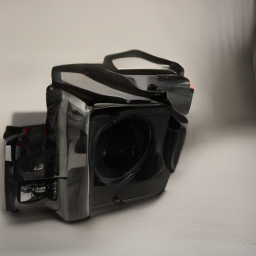

/content/EqM/generated/000003.png


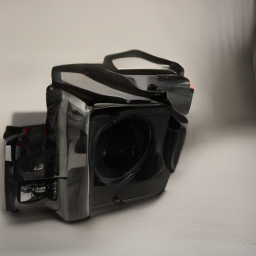

In [21]:
import glob
from PIL import Image
from IPython.display import display

paths = sorted(
    glob.glob("/content/EqM/generated/**/*.png", recursive=True)
    + glob.glob("/content/EqM/generated/*.png")
)
print("found", len(paths), "pngs")
for p in paths:
    print(p)
    display(Image.open(p))
